# Functional Principal Component Analysis
This workbook investigates how FPCA can be used to analyse the modes of motion of the intensity curve of trade arrival in financial markets

In [1]:
# import packages

import scipy.io as sio  # for loading matlab data

import numpy as np      # for numerical libs

import scipy as sci     # more scientific functions

from sklearn import datasets, linear_model  # for regression

import statsmodels.api as sm  # for robust regression

from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

C:\Users\Sebastian\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Load Data and Display Legendre Polynomial Regression

In [2]:
# load the data and store in an array volume
data = sio.loadmat('volume_INTC_2014.mat')

buy = np.array( data['volume']['volbuy'][0][0] )
sell = np.array( data['volume']['volsell'][0][0] )

# store volumes in one array
volume = np.zeros((2,buy.shape[0],buy.shape[1]))
volume[0,:,:] = np.log(1+buy)
volume[1,:,:] = np.log(1+sell)

# transformed times at which volumes are measured (equally spaced through the day at the mid of the interval)
tr = -1 + 1/(buy.shape[1]) + np.linspace(0,buy.shape[1]-1,buy.shape[1]) *2/(buy.shape[1])

# for plotting smooth fits
Nt = 1000
t = -1 + np.linspace(0,Nt-1,Nt) *2/(Nt)

In [3]:
# evalute Lengdre Polynomials up to order Kmax at the points t
def GenerateLengdrePolynomials(t, Kmax, makeplot=0):
    LP = np.zeros((Kmax,t.size))
    for k in range(0,Kmax):

        c = np.zeros(k+1)
        c[k]=1

        LP[k,:]=np.polynomial.legendre.legval(t,c)*np.sqrt(k+1/2)

        if makeplot:
            plt.subplot(1,Kmax,k+1)
            plt.plot(t,LP[k,:])
            plt.title(r'$L_' + str(k) +'(t)$')

    if makeplot:
        plt.tight_layout()
        plt.show()
    
    return LP

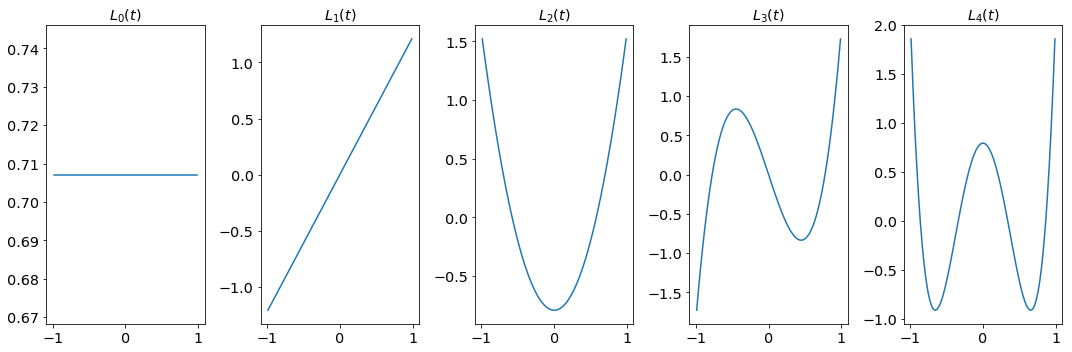

In [4]:
# Let's use 5 basis functions, and evaluate at the locations of the order-flow information
LPr = GenerateLengdrePolynomials(tr, 5, 1)
LPt = GenerateLengdrePolynomials(t, 5)

In [6]:
# robust regress data onto Legendre polynomials
def RegressData(x, LP):
    
    alpha = np.zeros((x.shape[0],LP.shape[0]))
    
    for i in range(0,x.shape[0]):
        regr = sm.RLM(x[i,:], LP.T, M=sm.robust.norms.HuberT())
        regr_results = regr.fit()
        alpha[i,:] = regr_results.params
        
    return alpha   




In [7]:
alpha = np.zeros((2,volume.shape[1],LPr.shape[0]))
alpha[0,:,:] = RegressData(volume[0,:,:],LPr)
alpha[1,:,:] = RegressData(volume[1,:,:],LPr)

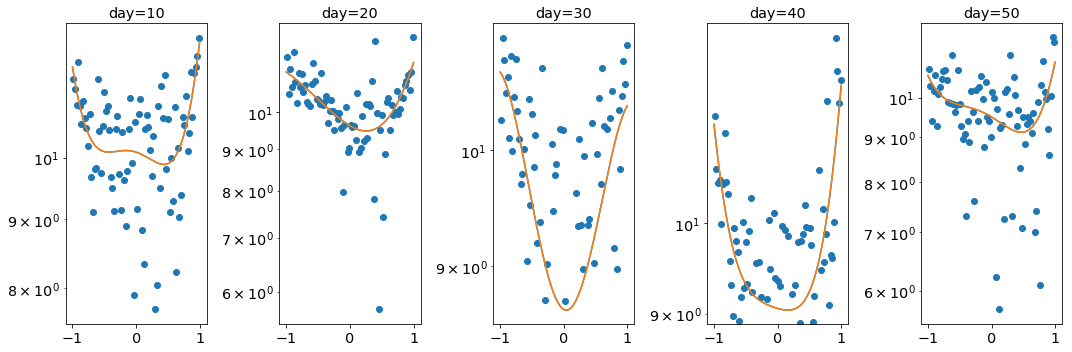

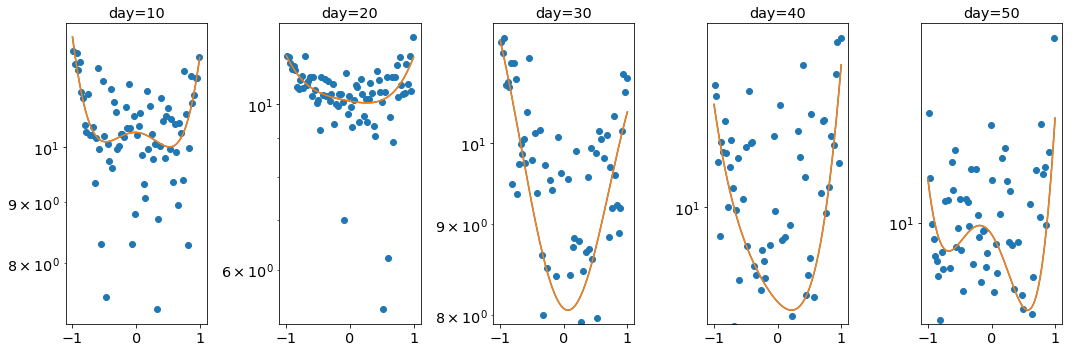

In [8]:
iplt = np.array([10,20,30,40,50])

def PlotFit(t, LPt, alpha, volume, iplt):

    for i in range(0,iplt.size):

        plt.subplot(1,iplt.size,i+1)
        plt.scatter(tr,volume[iplt[i],:])

        ax = plt.gca()
        ax.set_yscale('log')
        plt.plot(t, np.matmul(alpha[iplt[i],:], LPt))
        plt.semilogy(t, np.matmul(alpha[iplt[i],:], LPt))

        plt.title('day=' + str(iplt[i]))

    plt.tight_layout()    
    plt.show()
    
PlotFit(t, LPt, alpha[0,:,:], volume[0,:,:], iplt)
PlotFit(t, LPt, alpha[1,:,:], volume[1,:,:], iplt)

# Perform FPCA

In [9]:
def FPCA(alpha):
    
    N = alpha.shape[0]

    # the weight matrix
    W = np.zeros((alpha.shape[1],alpha.shape[1]))
    for i in range(W.shape[0]):
        W[i,i] = 1 
        
    X = sci.linalg.fractional_matrix_power(W,0.5)
    
    # subtract mean curve
    alpha0 = alpha - np.mean(alpha,axis=0)
    
    A = (1.0/N)*np.matmul(np.matmul(X,alpha0.T),np.matmul(alpha0,X))
        
    d, u = sci.linalg.eigh(A)
    
    print(d)
    print(u)
    
    b = np.matmul(sci.linalg.fractional_matrix_power(W,-0.5), u)
    
    return b, d 

In [10]:
def PlotFPC(t, LPt, alpha, b, d, K):
    
    malpha = np.mean(alpha, axis=0)
    
    m = d.size
    
    perc_var= np.floor(1000 * d/np.sum(d))/10
    
    
    for i in range(0,K):

        plt.subplot(1,K,i+1)
        plt.plot(t,np.matmul(malpha, LPt))
        plt.plot(t,np.matmul(malpha+np.sqrt(d[m-i-1])*b[:,m-i-1], LPt))
        plt.plot(t,np.matmul(malpha-np.sqrt(d[m-i-1])*b[:,m-i-1], LPt))
        #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.title( r'FPC ' + str(i+1) + ' : ' + str(perc_var[m-i-1]) +'%' )
        
    plt.tight_layout()
    plt.show()   

[ 0.01905232  0.0343359   0.05421489  0.10202459  0.56759654]
[[ 0.04864368  0.05233733 -0.14986326  0.26872479  0.9488006 ]
 [-0.13118309  0.52409735  0.26566188 -0.76283683  0.23583195]
 [ 0.43777604  0.26693522 -0.82491676 -0.21234898 -0.1073218 ]
 [-0.68571389  0.55564467 -0.26002468  0.36578209 -0.14016451]
 [ 0.56442306  0.58530963  0.3985778   0.40862983 -0.11400283]]


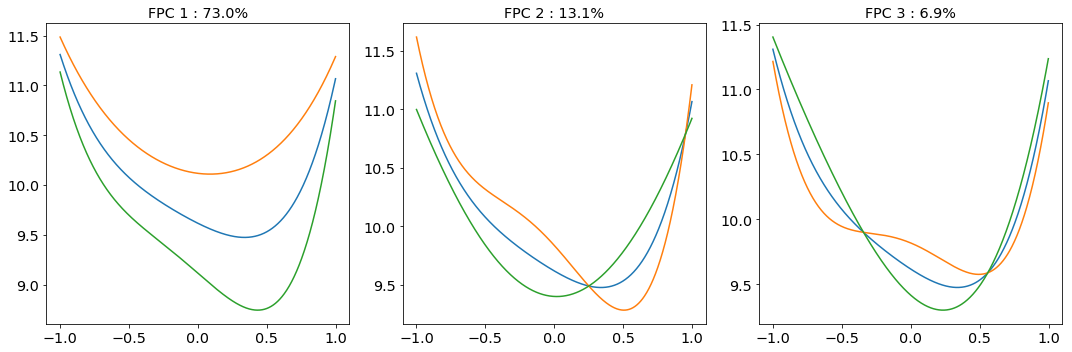

[ 0.02277744  0.03455076  0.06057253  0.13931181  0.64776148]
[[ 0.0709041  -0.00841741 -0.18326172  0.25195171  0.94754273]
 [-0.1327872   0.54365899  0.32796116 -0.7124689   0.26764159]
 [ 0.49231278  0.16265766 -0.7719172  -0.35671188 -0.08983926]
 [-0.58153207  0.61070139 -0.39000766  0.34995415 -0.11954235]
 [ 0.6299117   0.5522231   0.33300824  0.42331683 -0.09038407]]


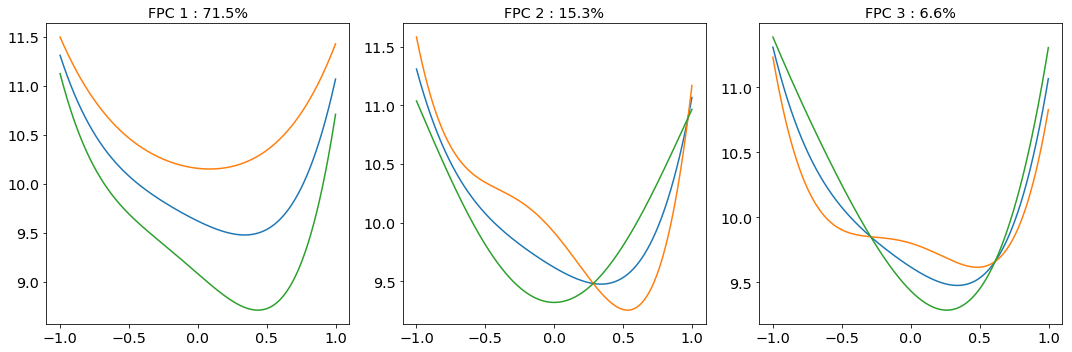

In [11]:
b, d = FPCA(alpha[0,:,:])
PlotFPC(t, LPt, alpha[1,:,:], b, d, 3)

b, d = FPCA(alpha[1,:,:])
PlotFPC(t, LPt, alpha[1,:,:], b, d, 3)